#POSTECH Research Project: Graph Classification 
###과제연구 1: Graph Classicafication

This notebook contains strenous endeavors of a procrastinator to get her work done before the deadly embarkment of the final proposal due date..
1.   Data Analysis
- Data will be imported and visualized through some means I hope..
2.   Data Preprocessing
- Data will be proprocessed to make this whole process actually possible
3.   GCN Implementation
- existing code with dataset will be tested than applied to own data
4. GAT Implementation
- existing code with dataset will be tested than applied to own data
5. GT Implementation
- existing code with dataset will be tested than applied to own data
6. Visual Representations
- Resulting data will be visually identified.. if possible :(



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Trial 1: Using StellarGraph

Firstly, StellarGraph's gcn implementation will be used to achieve graph classification. For now, classification will be done regarding to 2 classes: CN and not CN, which includes AD, ECMI, LCMI, SCM. After checking that this works well, classification regarding more then 2 classes may be attempted, or if the performance is not as high as expected, other models will be utilized.

Implementation based on : [StellarGraph: Supervised Graph Classification with GCN](https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/gcn-supervised-graph-classification.html)

In [2]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]
  #==1.2.1

     |████████████████████████████████| 440kB 15.1MB/s 
     |████████████████████████████████| 235kB 24.9MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 


In [3]:
import os
import pandas as pd
import numpy as np
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
# Don't Need for now!
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

#1. Load Data
Data provided by Prof. Kim Wonhwa is loaded to notebook. 
To run following code, a list of stellargraph instances and corresponding label list is necessary. The code below uses pd.Dataframes to achieve the conversion from .txt and .xlsx to stellargraph instances.

In [6]:
#import data
dt_map = pd.read_excel('/content/drive/MyDrive/research_proj_data/DT_File_MAP.xlsx')
dTS = pd.read_csv('/content/drive/MyDrive/research_proj_data/[UNC]ADNI-network/DataTS.csv')

#node features for each graph
dt_map_node_val = dt_map.drop(columns=['PTID', 'VISCODE', 'AGE', 'GENDER', 'EDUCATION', 'LABEL'])
nodes = list(dt_map_node_val.columns)[1:]

#graph labels
label = dt_map[['Subject','LABEL']]

In [7]:
#edge weights for each graph
edge_weight = {}
for x in os.listdir('/content/drive/MyDrive/research_proj_data/[UNC]ADNI-network/AD-Data'):
  f = open('/content/drive/MyDrive/research_proj_data/[UNC]ADNI-network/AD-Data/'+x, 'r')
  s = x.replace('_fdt_network_matrix', '')
  wdf = pd.DataFrame(np.loadtxt(f, dtype=int), columns=nodes)
  wdf.insert(0, 'source', nodes)
  edge_weight[s] = pd.melt(frame=wdf,id_vars='source', value_vars=nodes, var_name='target', value_name='weight' )
edge_weight

{'S100790':          source    target  weight
 0        Node 1    Node 1       0
 1        Node 2    Node 1    4100
 2        Node 3    Node 1   20487
 3        Node 4    Node 1     595
 4        Node 5    Node 1  239967
 ...         ...       ...     ...
 21899  Node 144  Node 148       1
 21900  Node 145  Node 148       3
 21901  Node 146  Node 148       0
 21902  Node 147  Node 148     229
 21903  Node 148  Node 148       0
 
 [21904 rows x 3 columns], 'S100849':          source    target  weight
 0        Node 1    Node 1       0
 1        Node 2    Node 1       0
 2        Node 3    Node 1       0
 3        Node 4    Node 1     243
 4        Node 5    Node 1  284063
 ...         ...       ...     ...
 21899  Node 144  Node 148       0
 21900  Node 145  Node 148       0
 21901  Node 146  Node 148     389
 21902  Node 147  Node 148  108860
 21903  Node 148  Node 148       0
 
 [21904 rows x 3 columns], 'S100964':          source    target  weight
 0        Node 1    Node 1       0
 

In [8]:
#node_features
node_features = {}
for s in dt_map_node_val['Subject']:
  r = dt_map_node_val[dt_map_node_val['Subject']==s]
  r_t = r.transpose()
  node_features[s] = r_t.drop(index='Subject')
  node_features[s].columns = ['values']
node_features['S100790']

,values
Node 1,1.884
Node 2,2.547
Node 3,2.282
Node 4,2.534
Node 5,2.385
...,...
Node 144,2.196
Node 145,2.161
Node 146,2.505
Node 147,2.347


In [9]:
#graph list
graphs = []
for s in dt_map_node_val['Subject']:
  g = StellarGraph(nodes=node_features[s], edges=edge_weight[s])
  graphs.append(g)


In [10]:
#Summary Statistics for graphs
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],)
summary.describe().round(1)

,nodes,edges
count,500.0,500.0
mean,148.0,21904.0
std,0.0,0.0
min,148.0,21904.0
25%,148.0,21904.0
50%,148.0,21904.0
75%,148.0,21904.0
max,148.0,21904.0


In [11]:
#one hot encode graph labels
graph_labels = label['LABEL']
graph_labels = pd.get_dummies(graph_labels)

graph_labels

,AD,CN,EMCI,LMCI,SMC
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
495,0,1,0,0,0
496,0,1,0,0,0
497,0,1,0,0,0
498,0,1,0,0,0


In [12]:
#Set labels to {CN, notCN}
#graph_labels['not CN'] = graph_labels[['AD', 'EMCI','LMCI','SMC']].sum(axis=1)
#graph_labels = graph_labels.drop(['AD', 'EMCI','LMCI','SMC'], axis=1)

In [13]:
graph_labels = graph_labels['CN'] #if 0 not CN if 1 CN
graph_labels

0      0
1      0
2      0
3      0
4      0
      ..
495    1
496    1
497    1
498    1
499    1
Name: CN, Length: 500, dtype: uint8

#Prepare Graph Generator
To feed data to the tf.Keras model that we will create later, we need a data generator. For supervised graph classification, we create an instance of StellarGraph’s PaddedGraphGenerator class. Note that graphs is a list of StellarGraph graph objects.


In [14]:
generator = PaddedGraphGenerator(graphs=graphs)

#Create the Keras graph classification model
We are now ready to create a `tf.Keras` graph classification model using StellarGraph’s `GraphClassification` class together with standard tf.Keras layers, e.g., Dense.

The input is the graph represented by its adjacency and node features matrices. The first two layers are Graph Convolutional as in [2] with each layer having 64 units and relu activations. The next layer is a mean pooling layer where the learned node representation are summarized to create a graph representation. The graph representation is input to two fully connected layers with 32 and 16 units respectively and relu activations. The last layer is the output layer with a single unit and sigmoid activation.

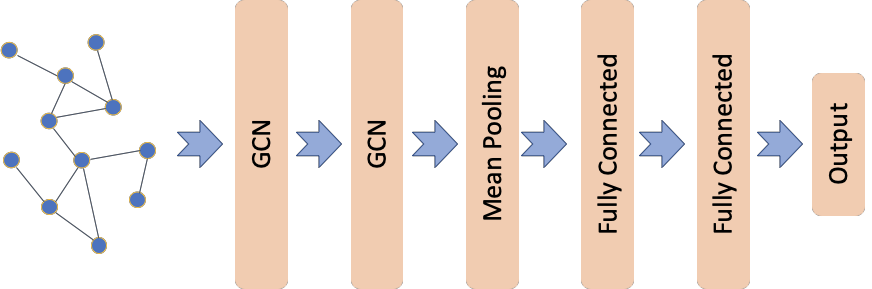


In [15]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model

#Train the Model using `fit`

In [16]:
#parameters

epochs = 200  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation
n_repeats = 5  # the number of repeats for repeated k-fold cross validation

es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [17]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [18]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

The code below puts all the above functionality together in a training loop for repeated k-fold cross-validation where the number of folds is 10, folds=10; that is we do 10-fold cross validation n_repeats times where n_repeats=5.

Note: The below code may take a long time to run depending on the value set for n_repeats. The larger the latter, the longer it takes since for each repeat we train and evaluate 10 graph classification models, one for each fold of the data. For progress updates, we recommend that you set verbose=2 in the call to the fit method is cell 10, line 3.

In [19]:
test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)

for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1 out of 50...
Training and evaluating on fold 2 out of 50...
Training and evaluating on fold 3 out of 50...
Training and evaluating on fold 4 out of 50...
Training and evaluating on fold 5 out of 50...
Training and evaluating on fold 6 out of 50...
Training and evaluating on fold 7 out of 50...
Training and evaluating on fold 8 out of 50...
Training and evaluating on fold 9 out of 50...
Training and evaluating on fold 10 out of 50...
Training and evaluating on fold 11 out of 50...
Training and evaluating on fold 12 out of 50...
Training and evaluating on fold 13 out of 50...
Training and evaluating on fold 14 out of 50...
Training and evaluating on fold 15 out of 50...
Training and evaluating on fold 16 out of 50...
Training and evaluating on fold 17 out of 50...
Training and evaluating on fold 18 out of 50...
Training and evaluating on fold 19 out of 50...
Training and evaluating on fold 20 out of 50...
Training and evaluating on fold 21 out of 50...
T

In [20]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 78.2% and std: 0.6%


#Visualization of Results

Text(0, 0.5, 'Count')

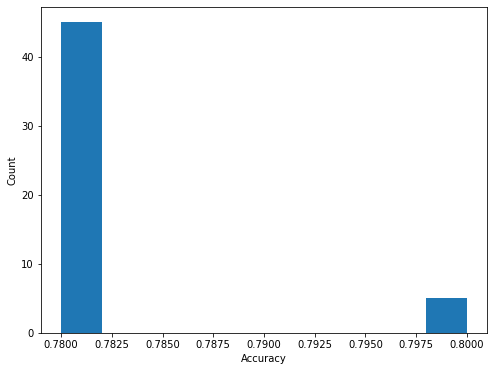

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")